In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd

In [2]:
transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
]),
'valid_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])}

In [3]:
trans = ['train_transforms','valid_transforms','test_transforms']

In [9]:
path = "/Users/user/Downloads/capstone_pneunomia/"  ##enter path
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}

In [10]:
dataset_sizes = {x : len(dset[x]) for x in categories}

In [11]:
for x in categories:
  print('{}: {}'.format(x,dataset_sizes[x]))

train: 2624
val: 226
test: 228


In [12]:
num_threads = 0
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories} 

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,2),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc =0.0
        if train_on_gpu:
            self.model = self.model.cuda()
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','test']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model

In [ ]:
model = Model()
model_ft = model.fit(dataloaders,100)

In [15]:
torch.save(model.state_dict(), "/Users/user/Downloads/capstone_pneunomia/best_pneumonia_model.pth")

In [16]:
state_dict = torch.load("/Users/user/Downloads/capstone_pneunomia/best_pneumonia_model.pth")
model.load_state_dict(state_dict, strict=False)
model_ft = model.model
model_ft = model_ft.eval()

In [17]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    model.train()

check_accuracy(dataloaders['train'], model)

In [ ]:
check_accuracy(dataloaders['test'], model)

In [20]:
class LayerActivations():
    features=[]
    def __init__(self, model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [21]:
def predict_img(path, model_ft):
  image_path = path
  img = image_loader(image_path)
  acts = LayerActivations(model_ft)
  img = img.cpu()
  logps = model_ft(img)
  ps = torch.exp(logps) 
  out_features = acts.features[0]
  out_features = torch.squeeze(out_features, dim=0)
  out_features = np.transpose(out_features.cpu(),axes=(1,2,0))
  W = model_ft.fc[0].weight
  top_probs, top_classes = torch.topk(ps, k=2)
  pred = np.argmax(ps.detach().cpu())
  w = W[pred,:]
  cam = np.dot(out_features.cpu(), w.detach().cpu())
  class_activation = nd.zoom(cam, zoom=(32,32),order=1)
  img = img.cpu()
  img = torch.squeeze(img,0)
  img = np.transpose(img,(1,2,0))
  mean = np.array([0.5,0.5,0.5])
  std =  np.array([0.5,0.5,0.5])
  img = img.numpy()
  img = (img + mean) * std
  img = np.clip(img, a_max=1, a_min=0)
  return img, class_activation, pred

In [22]:
test_dir="/Users/user/Downloads/capstone_pneunomia/Data_sample/"
from skimage.io import imread
from PIL import Image
import glob
image_list = []
for filename in glob.glob(test_dir+'/*.jpeg'): 
    #im=Image.open(filename)
    image_list.append(filename)

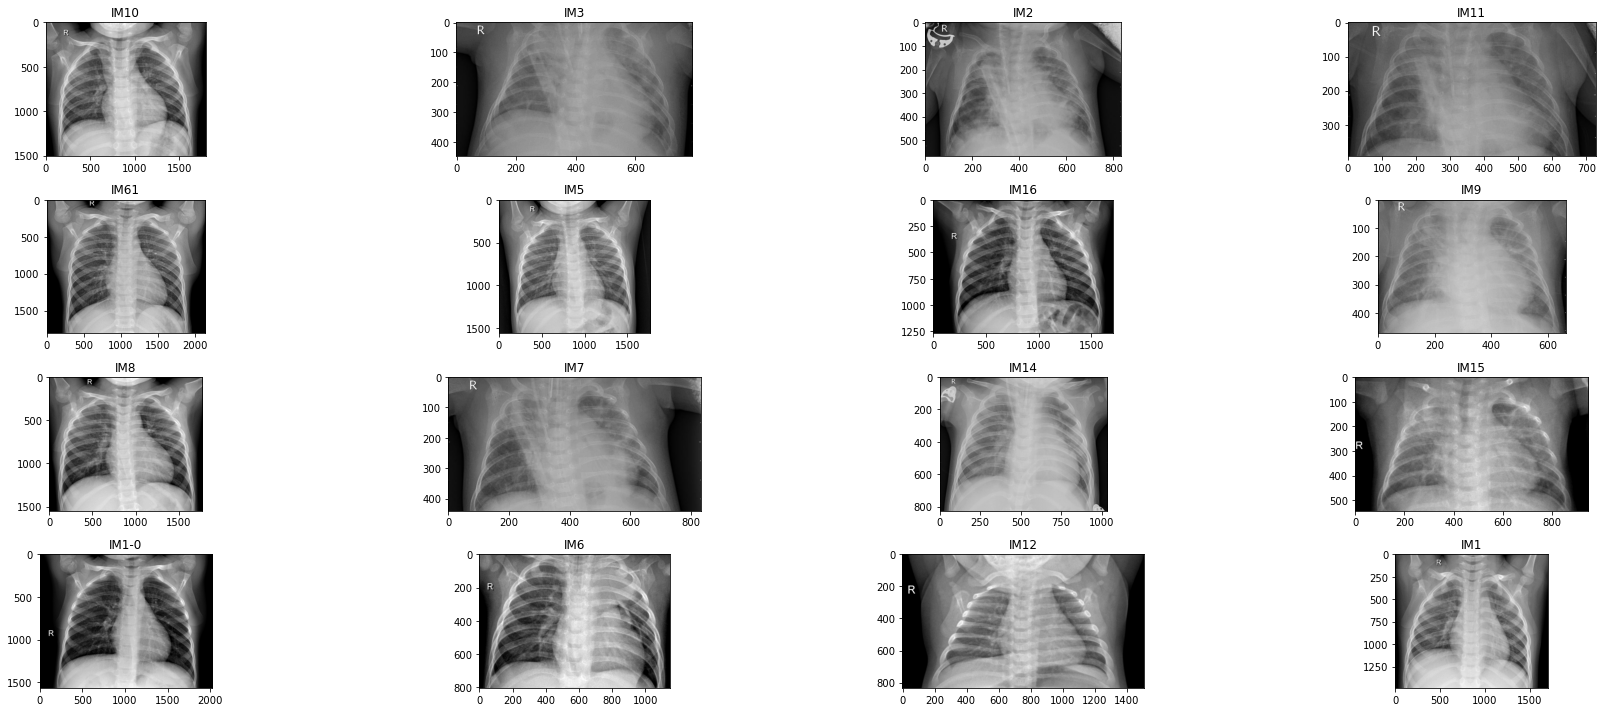

In [23]:
f, ax = plt.subplots(4,4, figsize=(30,10))

def plot_input(image_list):
  for i in range(len(image_list)):
      img = imread(image_list[i])
      name = image_list[i].split("/")
      name = name[len(name)-1].split(".")[0]
      ax[i//4, i%4].imshow(img, cmap='gray')
      ax[i//4, i%4].set_title(name)
      plt.tight_layout()
  plt.show()
plot_input(image_list)

1


tensor(1)

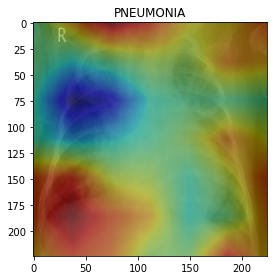

In [38]:
def predict_image(image, model_ft):
  img, class_activation, pred = predict_img(image, model_ft)
  print(pred.item())
  name = image.split("/")
  name = name[len(name)-1].split(".")[0]
  img = Image.fromarray((img * 255).astype(np.uint8))
  plt.ioff()
  plt.imshow(class_activation, cmap='jet',alpha=1)
  plt.imshow(img, alpha=0.55)
  plt.title(dset['test'].classes[pred])
  plt.tight_layout()

  # plt.show()
  return pred

predict_image(image_list[7], model_ft)

1


tensor(1)

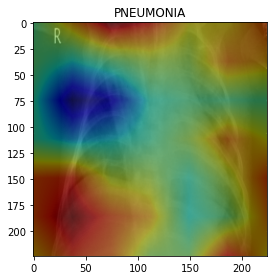

In [28]:
predict_image(image_list[1], model_ft)